<html> <h1> <b> Phân tích dự đoán ô nhiễm không khí </b> </h1></br>


---
<h2><b> Sử Dụng mô hình LSTM để dự đoán trong thời gian ngắn nhất đưa ra cảnh báo sớm nhất </b></h2>
</html>

<h3><b>1. Thực hiện kết nối drive và chèn các thư viện</h3></b>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install requests

In [ ]:
!pip install tensorflow scikit-learn

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from datetime import datetime, timedelta
import time
import csv
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

<h3><b>2. Thực hiện gửi yêu cầu requests đến api key của 2 website là openweather và apicn</h3></b>

In [ ]:
# API keys
OPENWEATHER_API_KEYS = [
    "a27dd428097b8fbfd40b20e22758e7d7",
    "d9952592b8f101ef3482d58f9ea3c1cb",
    "e704d15214c3552cec835b8de930edbf"
]
api_key_index = 0  # Chỉ số API Key hiện tại


In [ ]:
# Danh sách các tỉnh thành chia thành các nhóm nhỏ
province_groups = {
    "Group 1": ["Hanoi", "Hai Phong", "Quang Ninh", "Bac Ninh", "Bac Giang"],
    "Group 2": ["Lang Son", "Son La", "Hoa Binh", "Lao Cai", "Yen Bai"],
    "Group 3": ["Thai Nguyen", "Tuyen Quang", "Phu Tho", "Hai Duong", "Hung Yen"],
    "Group 4": ["Thai Binh", "Nam Dinh", "Ninh Binh", "Ha Nam", "Vinh Phuc"],
    "Group 5": ["Dien Bien", "Lai Chau", "Ha Giang", "Cao Bang", "Bac Kan"],
    "Group 6": ["Thanh Hoa", "Nghe An", "Ha Tinh", "Quang Binh", "Quang Tri"],
    "Group 7": ["Quang Nam", "Binh Dinh", "Phu Yen", "Khanh Hoa", "Ninh Thuan"],
    "Group 8": ["Binh Thuan", "Da Nang", "Quang Ngai", "Gia Lai", "Kon Tum"],
    "Group 9": ["Ho Chi Minh", "Dong Nai", "Binh Duong", "Ba Ria - Vung Tau", "Tay Ninh"],
    "Group 10": ["Long An", "Tien Giang", "Ben Tre", "Vinh Long", "Dong Thap"],
    "Group 11": ["Can Tho", "An Giang", "Kien Giang", "Soc Trang", "Tra Vinh"],
    "Group 12": ["Hau Giang", "Ca Mau", "Bac Lieu", "Phu Yen", "Binh Duong"],
    "Group 13": ["Gia Lai", "Kon Tum", "Dak Lak", "Dak Nong"]
}

In [ ]:
# Danh sách tọa độ của các tỉnh thành
coordinates = {
    "Hanoi": (21.0285, 105.8542),
    "Ho Chi Minh": (10.8231, 106.6297),
    "Da Nang": (16.0471, 108.2068),
    "Can Tho": (10.0452, 105.7469),
    "Hai Phong": (20.8449, 106.6881),
    "Quang Ninh": (21.0485, 107.0831),
    "Thua Thien Hue": (16.4637, 107.5902),
    "Bac Ninh": (21.1855, 106.0747),
    "Bac Giang": (21.2692, 106.1956),
    "Lang Son": (21.8471, 106.7689),
    "Thanh Hoa": (19.8080, 105.7799),
    "Nghe An": (19.2803, 105.6628),
    "Ha Tinh": (18.3385, 105.9041),
    "Quang Binh": (17.4599, 106.5972),
    "Quang Tri": (16.7741, 107.1345),
    "Quang Nam": (15.5720, 108.1500),
    "Binh Dinh": (13.7829, 109.2193),
    "Phu Yen": (13.0904, 109.3088),
    "Khanh Hoa": (12.2278, 109.1957),
    "Ninh Thuan": (11.5742, 108.9354),
    "Binh Thuan": (10.9317, 108.1017),
    "Dong Nai": (10.9510, 106.7724),
    "Ba Ria - Vung Tau": (10.3551, 107.1384),
    "Binh Duong": (10.9639, 106.6700),
    "Tay Ninh": (11.3555, 106.1731),
    "Long An": (10.3978, 106.4434),
    "Tien Giang": (10.3833, 106.3633),
    "Ben Tre": (10.2394, 106.3473),
    "Vinh Long": (10.2532, 105.9715),
    "Dong Thap": (10.5841, 105.7498),
    "An Giang": (10.4202, 105.0840),
    "Kien Giang": (10.0115, 104.9840),
    "Ca Mau": (9.1752, 105.1445),
    "Bac Lieu": (9.2900, 105.7149),
    "Soc Trang": (9.6013, 105.9737),
    "Tra Vinh": (9.9317, 106.3429),
    "Hau Giang": (9.8087, 105.5813),
    "Lam Dong": (11.9400, 108.4595),
    "Gia Lai": (13.9530, 108.4292),
    "Kon Tum": (14.3549, 108.0152),
    "Dak Lak": (12.6350, 108.2113),
    "Dak Nong": (11.9515, 107.6792),
    "Son La": (21.3143, 103.9183),
    "Dien Bien": (21.0000, 103.0167),
    "Lai Chau": (22.3300, 103.4667),
    "Hoa Binh": (20.8081, 105.3402),
    "Lao Cai": (22.5000, 103.9667),
    "Yen Bai": (21.7300, 104.8550),
    "Ha Giang": (22.8120, 104.9797),
    "Tuyen Quang": (21.8210, 105.2200),
    "Phu Tho": (21.3100, 105.2100),
    "Thai Nguyen": (21.5997, 105.8180),
    "Hai Duong": (20.9841, 106.2782),
    "Hung Yen": (20.9156, 106.0646),
    "Thai Binh": (20.4500, 106.3300),
    "Nam Dinh": (20.4067, 106.1633),
    "Ninh Binh": (20.2527, 105.9747),
    "Ha Nam": (20.5667, 105.9100),
    "Vinh Phuc": (21.3147, 105.5709),
    "Bac Kan": (22.1500, 105.6200),
    "Cao Bang": (22.6500, 106.2500),
}

In [ ]:
# Hàm chuyển đổi API Key
def get_next_openweather_api_key():
    global api_key_index
    key = OPENWEATHER_API_KEYS[api_key_index]
    api_key_index = (api_key_index + 1) % len(OPENWEATHER_API_KEYS)
    return key

# Hàm lấy dữ liệu thời tiết hiện tại
def fetch_current_weather(lat, lon):
    api_key = get_next_openweather_api_key()
    url = f"http://api.openweathermap.org/data/2.5/weather?lat={lat}&lon={lon}&appid={api_key}&units=metric"
    try:
        response = requests.get(url)
        if response.status_code == 200:
            return response.json()
        elif response.status_code == 429:
            print("API limit reached. Retrying after 60 seconds...")
            time.sleep(60)
            return fetch_current_weather(lat, lon)
        else:
            print(f"Failed to fetch current weather for ({lat}, {lon}): {response.text}")
            return None
    except requests.RequestException as e:
        print(f"Error fetching current weather for ({lat}, {lon}): {e}")
        return None

# Hàm lấy dữ liệu dự báo 5 ngày
def fetch_forecast(lat, lon):
    api_key = get_next_openweather_api_key()
    url = f"http://api.openweathermap.org/data/2.5/forecast?lat={lat}&lon={lon}&appid={api_key}&units=metric"
    try:
        response = requests.get(url)
        if response.status_code == 200:
            return response.json()
        elif response.status_code == 429:
            print("API limit reached. Retrying after 60 seconds...")
            time.sleep(60)
            return fetch_forecast(lat, lon)
        else:
            print(f"Failed to fetch forecast for ({lat}, {lon}): {response.text}")
            return None
    except requests.RequestException as e:
        print(f"Error fetching forecast for ({lat}, {lon}): {e}")
        return None

# Lưu dữ liệu vào CSV
def save_to_csv(data, filename="weather_data.csv"):
    with open(filename, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(data)

# Hàm xử lý dữ liệu theo tỉnh
def process_province_data(province, lat, lon, start_date, end_date):
    current_date = start_date
    while current_date <= end_date:
        # Lấy dữ liệu thời tiết hiện tại
        weather_data = fetch_current_weather(lat, lon)
        if weather_data:
            save_to_csv([
                province,
                lat,
                lon,
                current_date.strftime("%Y-%m-%d"),
                weather_data.get("main", {}).get("temp"),
                weather_data.get("main", {}).get("humidity"),
                weather_data.get("main", {}).get("pressure"),
                weather_data.get("wind", {}).get("speed"),
                weather_data.get("weather", [{}])[0].get("description", "No description"),
            ])
            print(f"Saved current weather data for {province} on {current_date.strftime('%Y-%m-%d')}")
        else:
            print(f"No data for {province} on {current_date.strftime('%Y-%m-%d')}")

        # Lấy dữ liệu dự báo 5 ngày (3 giờ/lần)
        forecast_data = fetch_forecast(lat, lon)
        if forecast_data:
            for forecast in forecast_data.get("list", []):
                forecast_time = datetime.strptime(forecast.get("dt_txt"), "%Y-%m-%d %H:%M:%S")
                if start_date <= forecast_time <= end_date:
                    save_to_csv([
                        province,
                        lat,
                        lon,
                        forecast_time.strftime("%Y-%m-%d %H:%M:%S"),
                        forecast.get("main", {}).get("temp"),
                        forecast.get("main", {}).get("humidity"),
                        forecast.get("main", {}).get("pressure"),
                        forecast.get("wind", {}).get("speed"),
                        forecast.get("weather", [{}])[0].get("description", "No description"),
                    ])
            print(f"Saved forecast data for {province}")

        # Chuyển sang ngày tiếp theo
        current_date += timedelta(days=1)

# Hàm xử lý từng nhóm
def process_province_groups(province_groups, start_date, end_date):
    for group_name, provinces in province_groups.items():
        print(f"Processing {group_name}...")
        for province in provinces:
            if province in coordinates:
                lat, lon = coordinates[province]
                process_province_data(province, lat, lon, start_date, end_date)
            else:
                print(f"Coordinates not found for {province}")
        print(f"Completed {group_name}. Waiting 30 seconds before next group...")
        time.sleep(30)

# Thời gian thu thập dữ liệu
start_date = datetime(2023, 11, 14)
end_date = datetime(2024, 11, 14)

# Chạy chương trình
if __name__ == "__main__":
    save_to_csv(["Province", "Latitude", "Longitude", "Date", "Temperature", "Humidity", "Pressure", "Wind Speed", "Weather Description"])
    process_province_groups(province_groups, start_date, end_date)


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
Saved forecast data for Bac Lieu
Saved current weather data for Bac Lieu on 2024-01-24
Saved forecast data for Bac Lieu
Saved current weather data for Bac Lieu on 2024-01-25
Saved forecast data for Bac Lieu
Saved current weather data for Bac Lieu on 2024-01-26
Saved forecast data for Bac Lieu
Saved current weather data for Bac Lieu on 2024-01-27
Saved forecast data for Bac Lieu
Saved current weather data for Bac Lieu on 2024-01-28
Saved forecast data for Bac Lieu
Saved current weather data for Bac Lieu on 2024-01-29
Saved forecast data for Bac Lieu
Saved current weather data for Bac Lieu on 2024-01-30
Saved forecast data for Bac Lieu
Saved current weather data for Bac Lieu on 2024-01-31
Saved forecast data for Bac Lieu
Saved current weather data for Bac Lieu on 2024-02-01
Saved forecast data for Bac Lieu
Saved current weather data for Bac Lieu on 2024-02-02
Saved forecast data for Bac Lieu
Saved current weather data for Bac Lieu 

In [ ]:
# Hàm chuyển đổi API Key
def get_next_openweather_api_key():
    global api_key_index
    key = OPENWEATHER_API_KEYS[api_key_index]
    api_key_index = (api_key_index + 1) % len(OPENWEATHER_API_KEYS)
    return key

# Hàm lấy dữ liệu ô nhiễm không khí
def fetch_air_pollution(lat, lon):
    api_key = get_next_openweather_api_key()
    url = f"http://api.openweathermap.org/data/2.5/air_pollution?lat={lat}&lon={lon}&appid={api_key}"
    try:
        response = requests.get(url)
        if response.status_code == 200:
            return response.json()
        elif response.status_code == 429:
            print("API limit reached. Retrying after 60 seconds...")
            time.sleep(60)
            return fetch_air_pollution(lat, lon)
        else:
            print(f"Failed to fetch air pollution data for ({lat}, {lon}): {response.text}")
            return None
    except requests.RequestException as e:
        print(f"Error fetching air pollution data for ({lat}, {lon}): {e}")
        return None

# Lưu dữ liệu vào CSV
def save_to_csv(data, filename="air_pollution_data.csv"):
    with open(filename, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(data)

# Hàm xử lý dữ liệu theo tỉnh
def process_province_air_data(province, lat, lon, start_date, end_date):
    current_date = start_date
    while current_date <= end_date:
        air_data = fetch_air_pollution(lat, lon)
        if air_data:
            components = air_data.get("list", [{}])[0].get("components", {})
            main = air_data.get("list", [{}])[0].get("main", {})
            save_to_csv([
                province,
                lat,
                lon,
                current_date.strftime("%Y-%m-%d"),
                components.get("co"),
                components.get("no"),
                components.get("no2"),
                components.get("o3"),
                components.get("so2"),
                components.get("pm2_5"),
                components.get("pm10"),
                components.get("nh3"),
                main.get("aqi")
            ])
            print(f"Saved air pollution data for {province} on {current_date.strftime('%Y-%m-%d')}")
        else:
            print(f"No air pollution data for {province} on {current_date.strftime('%Y-%m-%d')}")
        current_date += timedelta(days=1)

# Hàm xử lý từng nhóm
def process_province_groups(province_groups, start_date, end_date):
    for group_name, provinces in province_groups.items():
        print(f"Processing {group_name}...")
        for province in provinces:
            if province in coordinates:
                lat, lon = coordinates[province]
                process_province_air_data(province, lat, lon, start_date, end_date)
            else:
                print(f"Coordinates not found for {province}")
        print(f"Completed {group_name}. Waiting 30 seconds before next group...")
        time.sleep(30)

# Thời gian thu thập dữ liệu
start_date = datetime(2023, 11, 14)
end_date = datetime(2024, 11, 14)

# Chạy chương trình
if __name__ == "__main__":
    # Tạo file CSV với tiêu đề
    save_to_csv([
        "Province", "Latitude", "Longitude", "Date", "CO", "NO", "NO2",
        "O3", "SO2", "PM2.5", "PM10", "NH3", "AQI"
    ])
    process_province_groups(province_groups, start_date, end_date)


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
Saved air pollution data for Can Tho on 2024-04-05
Saved air pollution data for Can Tho on 2024-04-06
Saved air pollution data for Can Tho on 2024-04-07
Saved air pollution data for Can Tho on 2024-04-08
Saved air pollution data for Can Tho on 2024-04-09
Saved air pollution data for Can Tho on 2024-04-10
Saved air pollution data for Can Tho on 2024-04-11
Saved air pollution data for Can Tho on 2024-04-12
Saved air pollution data for Can Tho on 2024-04-13
Saved air pollution data for Can Tho on 2024-04-14
Saved air pollution data for Can Tho on 2024-04-15
Saved air pollution data for Can Tho on 2024-04-16
Saved air pollution data for Can Tho on 2024-04-17
Saved air pollution data for Can Tho on 2024-04-18
Saved air pollution data for Can Tho on 2024-04-19
Saved air pollution data for Can Tho on 2024-04-20
Saved air pollution data for Can Tho on 2024-04-21
Saved air pollution data for Can Tho on 2024-04-22
Saved air pollution data 

In [ ]:
import shutil

# Đường dẫn đến thư mục trong Google Drive
destination_folder = '/content/drive/MyDrive/Khoa_Luan'

# Chuyển tệp
shutil.move('weather_data.csv', destination_folder + 'weather_data.csv')
shutil.move('air_pollution_data.csv', destination_folder + 'air_pollution_data.csv')
print("Files have been moved to Google Drive!")


Files have been moved to Google Drive!


In [ ]:
!ls '/content/drive/MyDrive/Khoa_Luan'

'Json to Dataframe.ipynb'


<h3><b> Tiền xử lý Dữ Liệu </b></h3>

In [ ]:
# Đường dẫn đến tệp CSV trong Google Drive
air_pollution_file = '/content/drive/MyDrive/Khoa_Luan/air_pollution_data.csv'
weather_data_file = '/content/drive/MyDrive/Khoa_Luan/weather_data.csv'

# Đọc dữ liệu từ CSV
air_pollution_df = pd.read_csv(air_pollution_file)
weather_data_df = pd.read_csv(weather_data_file)

# Kiểm tra cấu trúc dữ liệu
print("Air Pollution Dataset:")
print(air_pollution_df.info())
print("\nWeather Dataset:")
print(weather_data_df.info())

# Hợp nhất hai dataset dựa trên các cột chung (nếu có)
merged_df = pd.merge(
    weather_data_df,
    air_pollution_df,
    on=['Province', 'Latitude', 'Longitude', 'Date'],
    how='outer'
)

# Kiểm tra dữ liệu sau khi hợp nhất
print("\nMerged Dataset:")
print(merged_df.info())
print(merged_df.head())

# Lưu dữ liệu hợp nhất vào CSV trên Google Drive
merged_file = '/content/drive/MyDrive/Khoa_Luan/merged_weather_air_pollution.csv'
merged_df.to_csv(merged_file, index=False)
print(f"Merged dataset saved to {merged_file}")


Air Pollution Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23121 entries, 0 to 23120
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Province   23121 non-null  object 
 1   Latitude   23121 non-null  float64
 2   Longitude  23121 non-null  float64
 3   Date       23121 non-null  object 
 4   CO         23121 non-null  float64
 5   NO         23121 non-null  float64
 6   NO2        23121 non-null  float64
 7   O3         23121 non-null  float64
 8   SO2        23121 non-null  float64
 9   PM2.5      23121 non-null  float64
 10  PM10       23121 non-null  float64
 11  NH3        23121 non-null  float64
 12  AQI        23121 non-null  int64  
dtypes: float64(10), int64(1), object(2)
memory usage: 2.3+ MB
None

Weather Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23121 entries, 0 to 23120
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------             

In [ ]:
from google.colab import drive
import pandas as pd
import ast

# Đường dẫn đến tệp trên Drive (thay thế bằng đường dẫn của bạn)
file_path = '/content/drive/MyDrive/Khoa_Luan/merged_weather_air_pollution.csv'

# Đọc file CSV
data = pd.read_csv(file_path, header=None)

# Hiển thị một số dòng đầu tiên để kiểm tra cấu trúc
data.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,Province,Latitude,Longitude,Date,Temperature,Humidity,Pressure,Wind Speed,Weather Description,CO,NO,NO2,O3,SO2,PM2.5,PM10,NH3,AQI
1,An Giang,10.4202,105.084,2023-11-14,28.84,68,1011,2.15,overcast clouds,660.9,0.23,2.08,98.71,2.0,59.14,64.11,5.13,4
2,An Giang,10.4202,105.084,2023-11-15,28.84,68,1011,2.15,overcast clouds,660.9,0.23,2.08,98.71,2.0,59.14,64.11,5.13,4
3,An Giang,10.4202,105.084,2023-11-16,28.84,68,1011,2.15,overcast clouds,660.9,0.23,2.08,98.71,2.0,59.14,64.11,5.13,4
4,An Giang,10.4202,105.084,2023-11-17,28.84,68,1011,2.15,overcast clouds,660.9,0.23,2.08,98.71,2.0,59.14,64.11,5.13,4


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Khoa_Luan/merged_weather_air_pollution.csv")
df

,Province,Latitude,Longitude,Date,Temperature,Humidity,Pressure,Wind Speed,Weather Description,CO,NO,NO2,O3,SO2,PM2.5,PM10,NH3,AQI
0,An Giang,10.4202,105.084,2023-11-14,28.84,68,1011,2.15,overcast clouds,660.90,0.23,2.08,98.71,2.00,59.14,64.11,5.13,4
1,An Giang,10.4202,105.084,2023-11-15,28.84,68,1011,2.15,overcast clouds,660.90,0.23,2.08,98.71,2.00,59.14,64.11,5.13,4
2,An Giang,10.4202,105.084,2023-11-16,28.84,68,1011,2.15,overcast clouds,660.90,0.23,2.08,98.71,2.00,59.14,64.11,5.13,4
3,An Giang,10.4202,105.084,2023-11-17,28.84,68,1011,2.15,overcast clouds,660.90,0.23,2.08,98.71,2.00,59.14,64.11,5.13,4
4,An Giang,10.4202,105.084,2023-11-18,28.84,68,1011,2.15,overcast clouds,660.90,0.23,2.08,98.71,2.00,59.14,64.11,5.13,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26052,Yen Bai,21.7300,104.855,2024-11-10,28.04,56,1018,1.17,clear sky,574.11,0.03,2.83,77.25,3.25,55.06,56.18,0.71,4
26053,Yen Bai,21.7300,104.855,2024-11-11,28.04,56,1018,1.17,clear sky,574.11,0.03,2.83,77.25,3.25,55.06,56.18,0.71,4
26054,Yen Bai,21.7300,104.855,2024-11-12,28.04,56,1018,1.17,clear sky,574.11,0.03,2.83,77.25,3.25,55.06,56.18,0.71,4
26055,Yen Bai,21.7300,104.855,2024-11-13,28.04,56,1018,1.17,clear sky,574.11,0.03,2.83,77.25,3.25,55.06,56.18,0.71,4


In [ ]:
# Kiểm tra danh sách các cột hiện có trong DataFrame
print("Các cột có sẵn trong DataFrame:", df.columns)

Các cột có sẵn trong DataFrame: Index(['Province', 'Latitude', 'Longitude', 'Date', 'Temperature', 'Humidity',
       'Pressure', 'Wind Speed', 'Weather Description', 'CO', 'NO', 'NO2',
       'O3', 'SO2', 'PM2.5', 'PM10', 'NH3', 'AQI'],
      dtype='object')


In [ ]:
df.columns = df.columns.str.strip()  # Loại bỏ khoảng trắng thừa
df.columns = df.columns.str.lower()  # Đổi tên cột thành chữ thường để dễ sử dụng
print(df.columns)


Index(['province', 'latitude', 'longitude', 'temperature', 'humidity',
       'pressure', 'wind speed', 'weather description', 'co', 'no', 'no2',
       'o3', 'so2', 'pm2.5', 'pm10', 'nh3', 'aqi', 'co_to_pm2_5',
       'no_to_pm2_5', 'nox', 'nox_to_pm2_5', 'total_pollutant',
       'avg_pollutant', 'pm2_5_to_pm10', 'co_no_interaction',
       'so2_o3_interaction', 'co_squared', 'log_pm2_5', 'high_pm2_5',
       'high_co', 'aqi_category'],
      dtype='object')


In [ ]:
df.columns = df.columns.str.strip()

In [ ]:
# Kiểm tra giá trị rỗng (NaN)
print(df.isnull().sum())

# Tùy chọn: Lọc ra các dòng có lỗi định dạng (nếu có)
for col in df.columns:
    # Kiểm tra lỗi chuyển đổi từng cột về kiểu dữ liệu phù hợp
    try:
        df[col] = df[col].astype(float)
    except ValueError:
        print(f"Cột '{col}' chứa dữ liệu không hợp lệ cho kiểu số.")


Province               0
Latitude               0
Longitude              0
Date                   0
Temperature            0
Humidity               0
Pressure               0
Wind Speed             0
Weather Description    0
CO                     0
NO                     0
NO2                    0
O3                     0
SO2                    0
PM2.5                  0
PM10                   0
NH3                    0
AQI                    0
dtype: int64
Cột 'Province' chứa dữ liệu không hợp lệ cho kiểu số.
Cột 'Date' chứa dữ liệu không hợp lệ cho kiểu số.
Cột 'Weather Description' chứa dữ liệu không hợp lệ cho kiểu số.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26057 entries, 0 to 26056
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Province             26057 non-null  object 
 1   Latitude             26057 non-null  float64
 2   Longitude            26057 non-null  float64
 3   Date                 26057 non-null  object 
 4   Temperature          26057 non-null  float64
 5   Humidity             26057 non-null  float64
 6   Pressure             26057 non-null  float64
 7   Wind Speed           26057 non-null  float64
 8   Weather Description  26057 non-null  object 
 9   CO                   26057 non-null  float64
 10  NO                   26057 non-null  float64
 11  NO2                  26057 non-null  float64
 12  O3                   26057 non-null  float64
 13  SO2                  26057 non-null  float64
 14  PM2.5                26057 non-null  float64
 15  PM10                 26057 non-null 

<h3><b> Phân tích dữ liệu thăm dò(EDA) </b></h3>

In [ ]:
#Kiểm tra giá trị null
null_pct = df.apply(pd.isnull).sum()/df.shape[0]
null_pct

,0
Province,0.0
Latitude,0.0
Longitude,0.0
Date,0.0
Temperature,0.0
Humidity,0.0
Pressure,0.0
Wind Speed,0.0
Weather Description,0.0
CO,0.0


In [ ]:
# Lọc Bảng Dữ liệu
valid_columns = df.dropna(axis=1, thresh=int(0.95 * len(df)))
print(valid_columns)

       Province  Latitude  Longitude        Date  Temperature  Humidity  \
0      An Giang   10.4202    105.084  2023-11-14        28.84      68.0   
1      An Giang   10.4202    105.084  2023-11-15        28.84      68.0   
2      An Giang   10.4202    105.084  2023-11-16        28.84      68.0   
3      An Giang   10.4202    105.084  2023-11-17        28.84      68.0   
4      An Giang   10.4202    105.084  2023-11-18        28.84      68.0   
...         ...       ...        ...         ...          ...       ...   
26052   Yen Bai   21.7300    104.855  2024-11-10        28.04      56.0   
26053   Yen Bai   21.7300    104.855  2024-11-11        28.04      56.0   
26054   Yen Bai   21.7300    104.855  2024-11-12        28.04      56.0   
26055   Yen Bai   21.7300    104.855  2024-11-13        28.04      56.0   
26056   Yen Bai   21.7300    104.855  2024-11-14        28.04      56.0   

       Pressure  Wind Speed Weather Description      CO    NO   NO2     O3  \
0        1011.0      

In [ ]:
# Kiểm tra giá trị bị thiếu
print(df.isna().sum())

Province               0
Latitude               0
Longitude              0
Date                   0
Temperature            0
Humidity               0
Pressure               0
Wind Speed             0
Weather Description    0
CO                     0
NO                     0
NO2                    0
O3                     0
SO2                    0
PM2.5                  0
PM10                   0
NH3                    0
AQI                    0
dtype: int64


In [ ]:
# Hiển thị mẫu dữ liệu

df.sample(1).iloc[0]

,17387
Province,Nghe An
Latitude,19.2803
Longitude,105.6628
Date,2024-03-31
Temperature,26.74
Humidity,68.0
Pressure,1017.0
Wind Speed,5.53
Weather Description,scattered clouds
CO,947.95


In [ ]:
print(df.describe())

           Latitude     Longitude   Temperature      Humidity      Pressure  \
count  26057.000000  26057.000000  26057.000000  26057.000000  26057.000000   
mean      15.684470    106.609146     27.693925     63.631116   1014.239437   
std        4.729185      1.445518      2.388189      8.241771      3.341923   
min        9.175200    103.016700     18.530000     45.000000   1010.000000   
25%       10.963900    105.746900     26.810000     56.000000   1011.000000   
50%       14.354900    106.342900     27.880000     64.000000   1013.000000   
75%       20.984100    108.015200     29.620000     69.000000   1018.000000   
max       22.812000    109.308800     31.730000     80.000000   1020.000000   

         Wind Speed            CO            NO           NO2            O3  \
count  26057.000000  26057.000000  26057.000000  26057.000000  26057.000000   
mean       3.065407    536.173239      0.506901      6.677465     78.300423   
std        1.493123    230.691763      0.913062    

In [ ]:
print("Số lượng dòng bị trùng lặp:", df.duplicated().sum())


Số lượng dòng bị trùng lặp: 3102


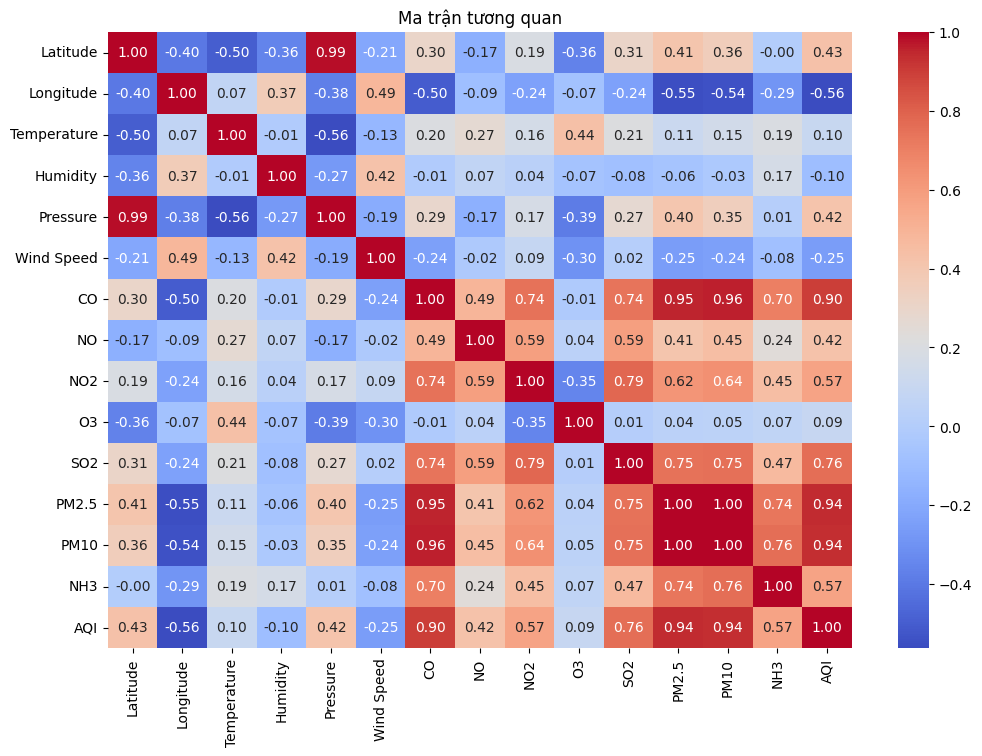

In [ ]:
# Lọc ra các cột số
numeric_df = df.select_dtypes(include=[float, int])

# Tính toán ma trận tương quan
correlation_matrix = numeric_df.corr()

# Vẽ biểu đồ ma trận tương quan
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Ma trận tương quan')
plt.show()


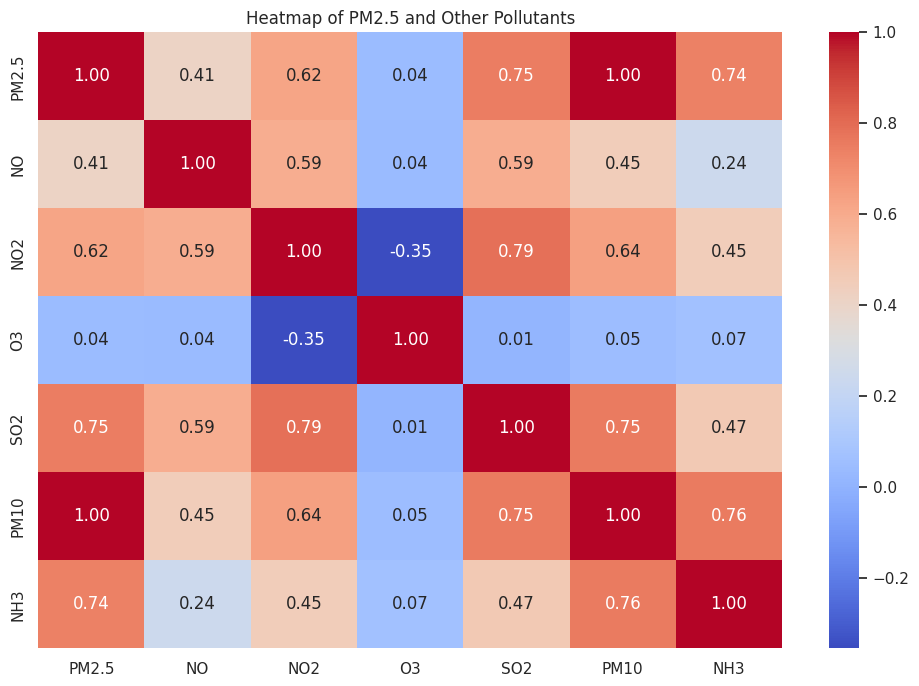

In [ ]:
# Lọc ra các cột cần thiết
selected_columns = ['PM2.5', 'CO', 'NO', 'NO2', 'O3', 'SO2', 'PM10', 'NH3']

# Tính toán ma trận tương quan giữa PM2.5 và các chất ô nhiễm khác
correlation_matrix = df[selected_columns].corr()

# Vẽ biểu đồ heatmap của ma trận tương quan
mp.figure(figsize=(12, 8))
sn.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

# Thêm tiêu đề
mp.title('Heatmap of PM2.5 and Other Pollutants')

# Hiển thị biểu đồ
mp.show()


In [ ]:
# Kiểm tra tỷ lệ giá trị bị thiếu  (missing values) trong mỗi cột
missing_data = df.isnull().sum()
print("Missing values in each column:\n", missing_data)

Missing values in each column:
 Province               0
Latitude               0
Longitude              0
Date                   0
Temperature            0
Humidity               0
Pressure               0
Wind Speed             0
Weather Description    0
CO                     0
NO                     0
NO2                    0
O3                     0
SO2                    0
PM2.5                  0
PM10                   0
NH3                    0
AQI                    0
dtype: int64


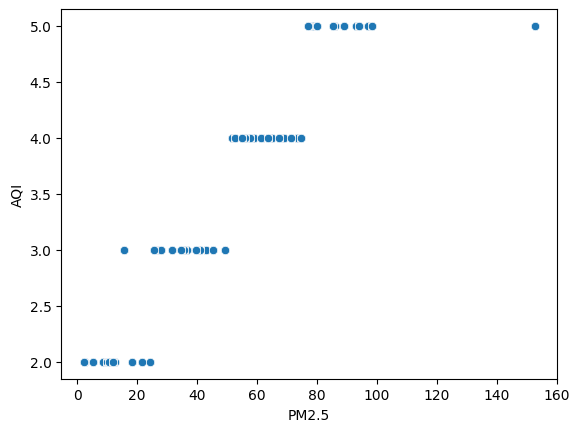

In [ ]:
# Kiểm tra mối quan hệ bằng biểu đồ phân tán (scatter plot)
sns.scatterplot(x=df['PM2.5'], y=df['AQI'])
plt.show()

In [ ]:
corr = df['PM2.5'].corr(df['PM10'])
print(f"Hệ số tương quan giữa Humidity và Pressure: {corr:.2f}")


Hệ số tương quan giữa Humidity và Pressure: 1.00


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)  # Đặt `Date` làm chỉ mục thời gian

<h3> <b> Phân phối giá trị của các biến (Distribution Visualization) </b></h3>
Kiểm tra phân phối của từng biến (bình thường, lệch phải/trái hay có giá trị ngoại lai).



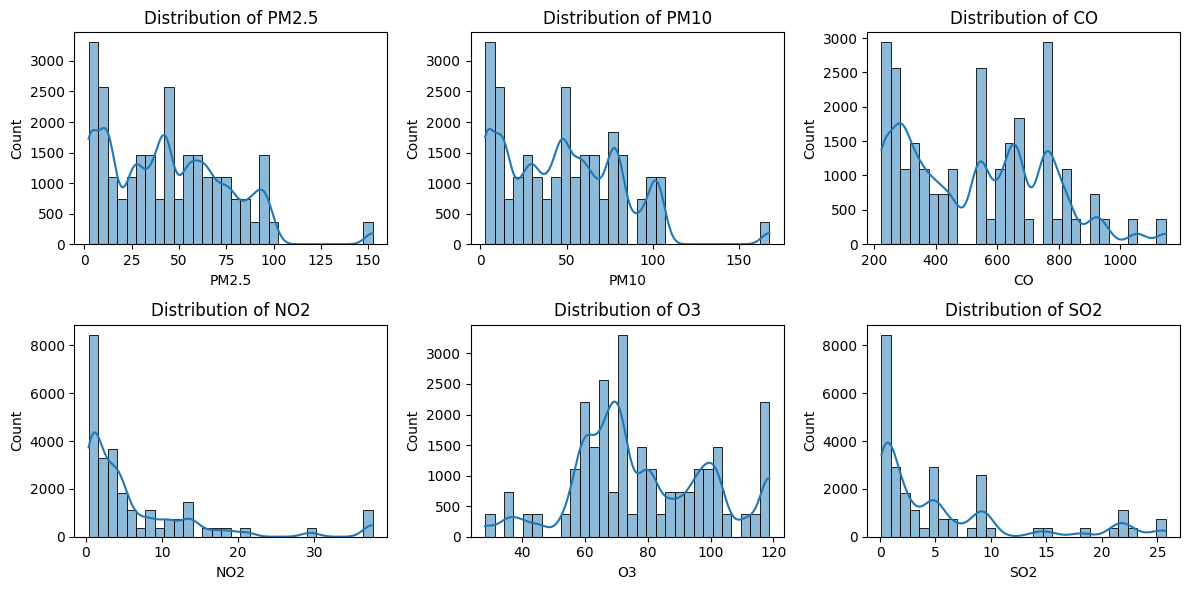

In [ ]:
plt.figure(figsize=(12, 6))
for i, col in enumerate(['PM2.5', 'PM10', 'CO', 'NO2', 'O3', 'SO2']):
    plt.subplot(2, 3, i+1)  # Sử dụng lưới con 2x3 thay vì 2x2
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


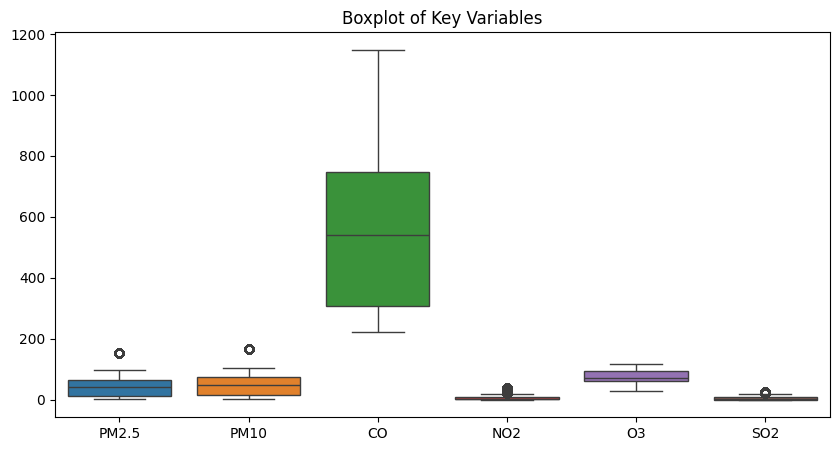

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df[['PM2.5', 'PM10', 'CO', 'NO2', 'O3', 'SO2']])
plt.title('Boxplot of Key Variables')
plt.show()


Xác định mối liên hệ giữa PM2.5 với các yếu tố ảnh hưởng, kiểm tra mức độ tương quan.

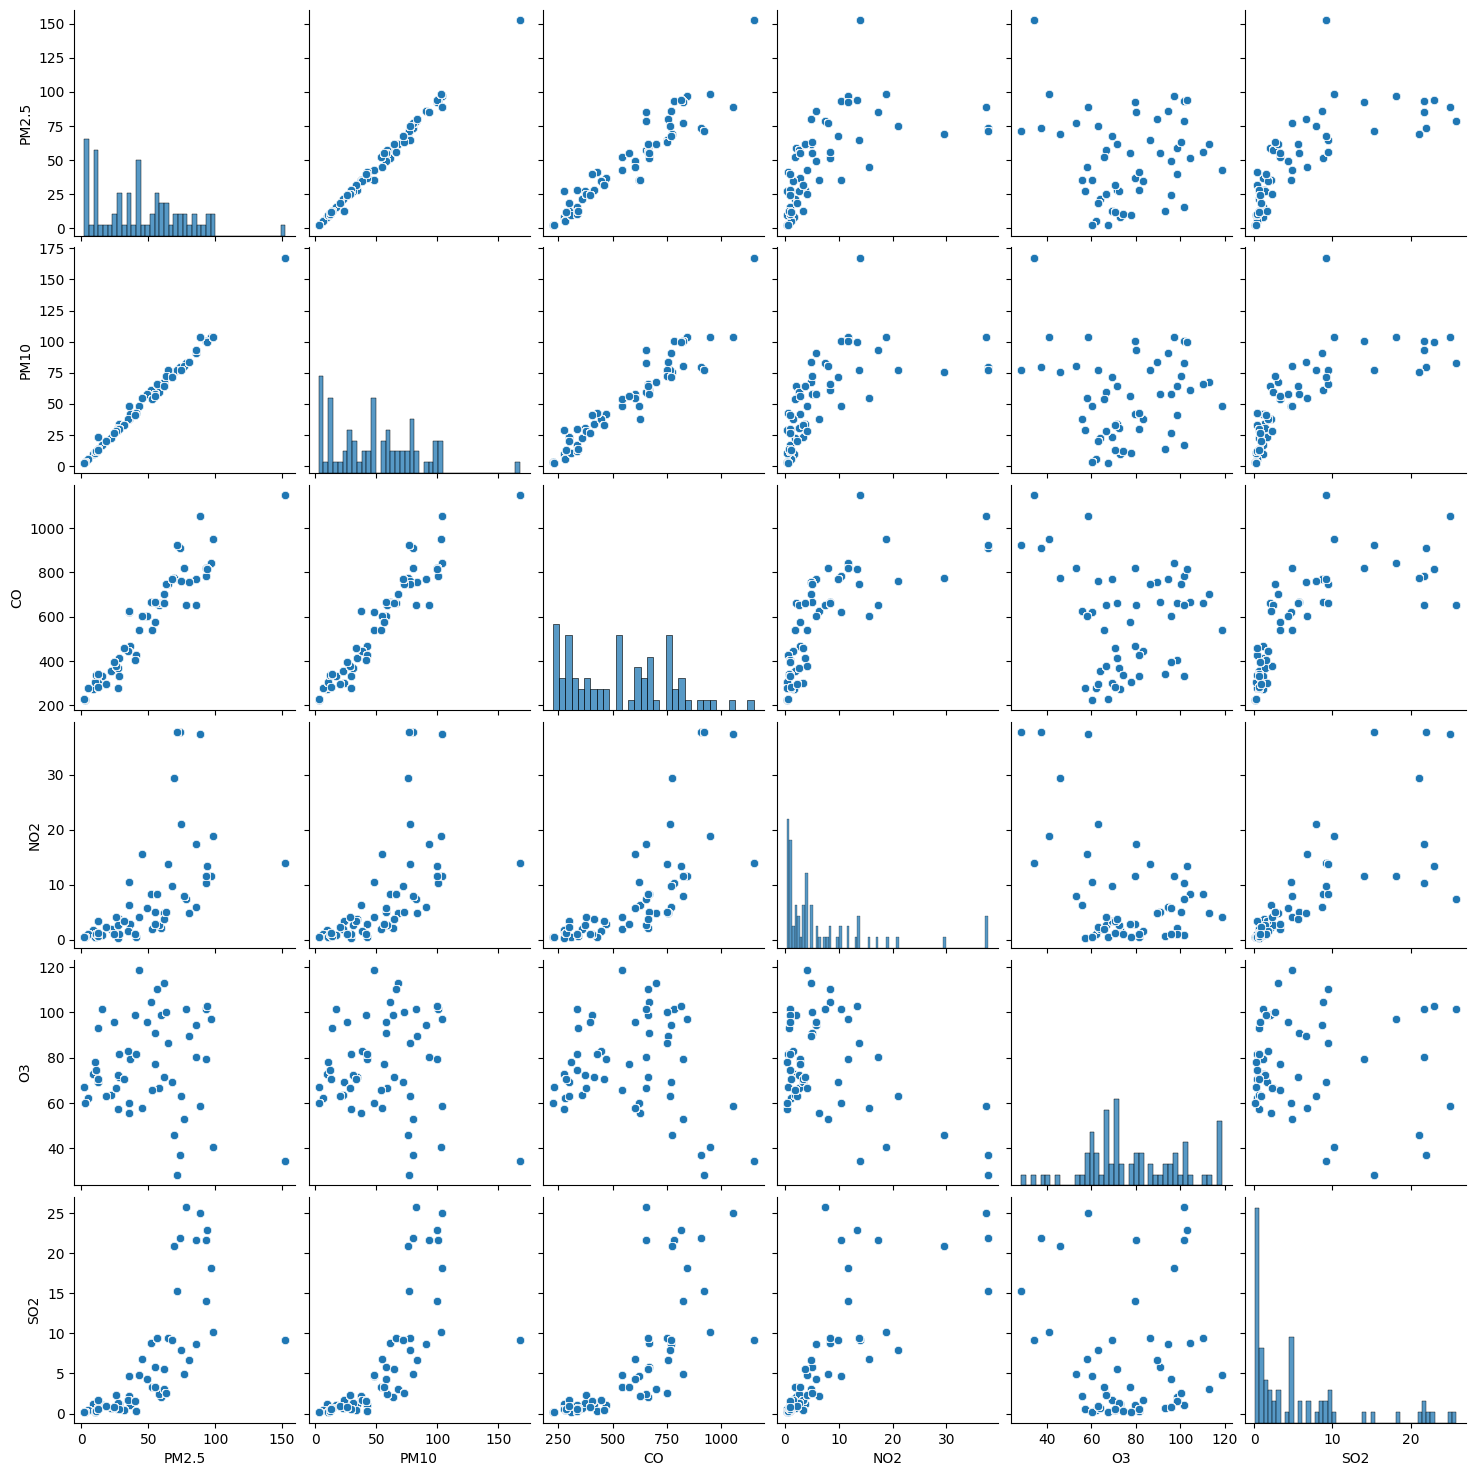

In [ ]:
sns.pairplot(df[['PM2.5', 'PM10', 'CO', 'NO2', 'O3', 'SO2']])
plt.show()


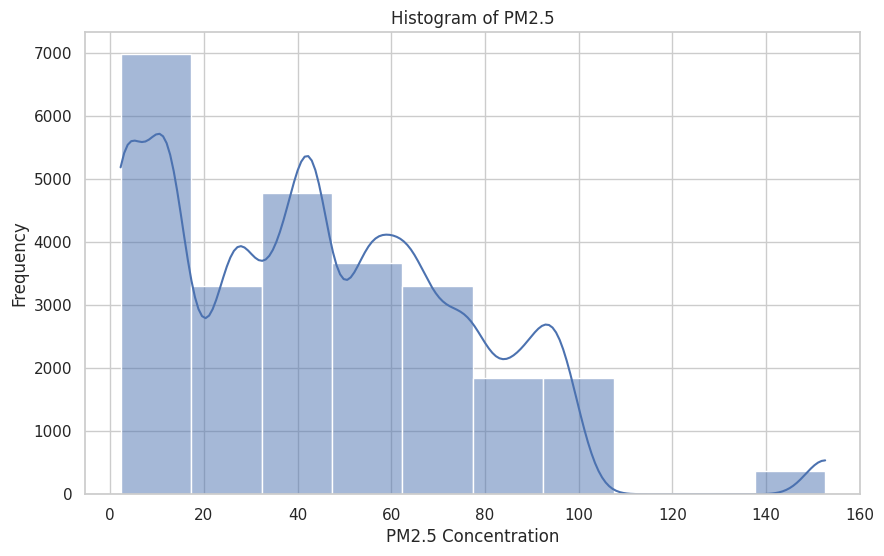

In [ ]:
import seaborn as sn
import matplotlib.pyplot as mp
sn.set(style="whitegrid")

# 1. Histogram of PM2.5
mp.figure(figsize=(10, 6))
sn.histplot(df['PM2.5'], bins=10, kde=True)
mp.title('Histogram of PM2.5')
mp.xlabel('PM2.5 Concentration')
mp.ylabel('Frequency')
mp.show()

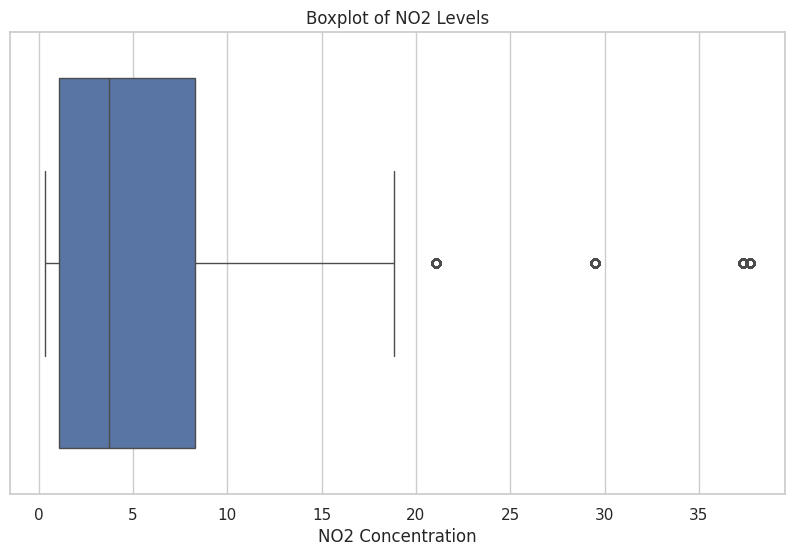

In [ ]:
mp.figure(figsize=(10, 6))
sn.boxplot(x=df['NO2'])
mp.title('Boxplot of NO2 Levels')
mp.xlabel('NO2 Concentration')
mp.show()

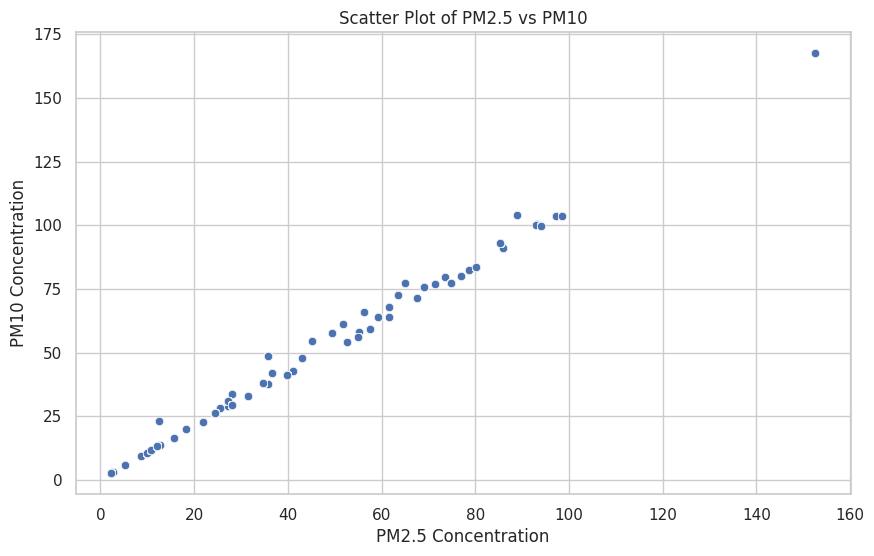

In [ ]:
mp.figure(figsize=(10, 6))
sn.scatterplot(x='PM2.5', y='PM10', data=df)
mp.title('Scatter Plot of PM2.5 vs PM10')
mp.xlabel('PM2.5 Concentration')
mp.ylabel('PM10 Concentration')
mp.show()

In [ ]:
mp.figure(figsize=(10, 10))
sn.pairplot(df,hue='PM2.5')
mp.title('Pairplot of Air Quality Features')
mp.show()

In [ ]:
numeric_df.corr()

,Latitude,Longitude,Temperature,Humidity,Pressure,Wind Speed,CO,NO,NO2,O3,SO2,PM2.5,PM10,NH3,AQI
Latitude,1.000000,-0.402498,-0.499563,-0.355583,0.987335,-0.209950,0.298305,-0.169754,0.194017,-0.364840,0.307574,0.409902,0.356138,-0.000284,0.432174
Longitude,-0.402498,1.000000,0.070019,0.369151,-0.379430,0.485766,-0.504937,-0.092018,-0.237398,-0.071628,-0.237426,-0.552653,-0.542833,-0.293549,-0.560688
Temperature,-0.499563,0.070019,1.000000,-0.007546,-0.562784,-0.134527,0.202347,0.266613,0.163025,0.436924,0.209998,0.114533,0.149517,0.194778,0.099298
Humidity,-0.355583,0.369151,-0.007546,1.000000,-0.272839,0.421915,-0.012561,0.071701,0.035018,-0.066853,-0.081259,-0.058377,-0.030511,0.165398,-0.098676
Pressure,0.987335,-0.379430,-0.562784,-0.272839,1.000000,-0.186739,0.291506,-0.170178,0.171116,-0.385755,0.272284,0.403118,0.350745,0.013894,0.416781
Wind Speed,-0.209950,0.485766,-0.134527,0.421915,-0.186739,1.000000,-0.244013,-0.023120,0.086332,-0.301249,0.017125,-0.253416,-0.242711,-0.080789,-0.252355
CO,0.298305,-0.504937,0.202347,-0.012561,0.291506,-0.244013,1.000000,0.491575,0.744664,-0.014926,0.743381,0.951704,0.958238,0.703094,0.902253
NO,-0.169754,-0.092018,0.266613,0.071701,-0.170178,-0.023120,0.491575,1.000000,0.587574,0.035741,0.589388,0.409117,0.449215,0.241220,0.420359
NO2,0.194017,-0.237398,0.163025,0.035018,0.171116,0.086332,0.744664,0.587574,1.000000,-0.353691,0.785420,0.621796,0.640418,0.445855,0.571992
O3,-0.364840,-0.071628,0.436924,-0.066853,-0.385755,-0.301249,-0.014926,0.035741,-0.353691,1.000000,0.009726,0.040629,0.046706,0.065724,0.092321


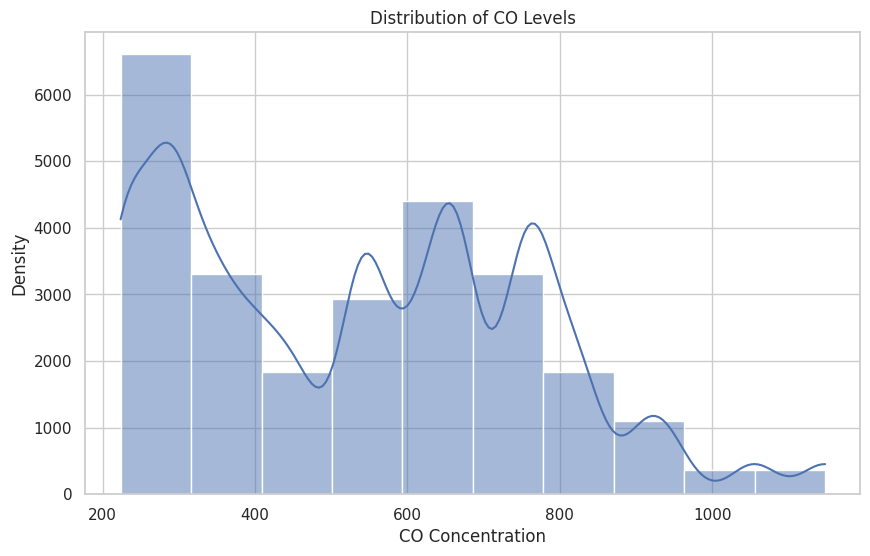

In [ ]:
mp.figure(figsize=(10, 6))
sn.histplot(df['CO'], bins=10, kde=True)
mp.title('Distribution of CO Levels')
mp.xlabel('CO Concentration')
mp.ylabel('Density')
mp.show()

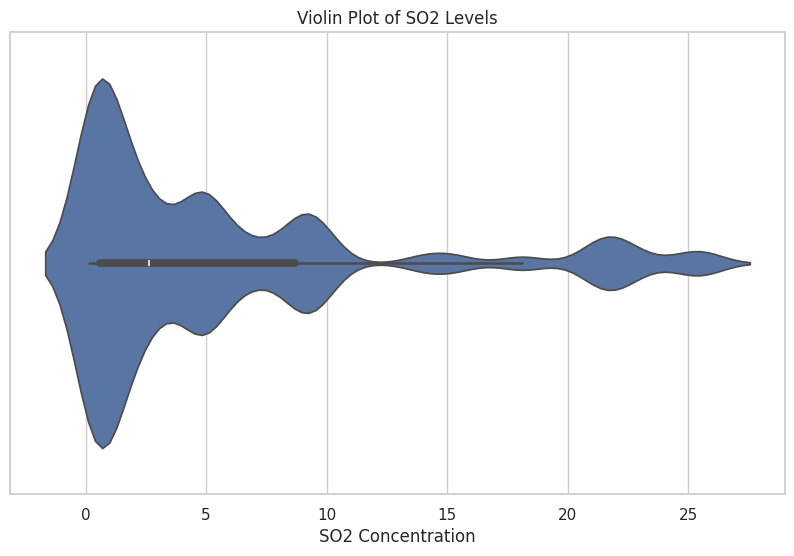

In [ ]:
mp.figure(figsize=(10, 6))
sn.violinplot(x=df['SO2'])
mp.title('Violin Plot of SO2 Levels')
mp.xlabel('SO2 Concentration')
mp.show()

In [ ]:
# 1. Tính tỷ lệ CO với PM2.5
df['co_to_pm2_5'] = df['CO'] / df['PM2.5']

# 2. Tính tỷ lệ NO với PM2.5
df['no_to_pm2_5'] = df['NO'] / df['PM2.5']

# 3. Tính NOx từ NO và NO2
df['nox'] = df['NO'] + df['NO2']

# 4. Tính tỷ lệ NOx với PM2.5
df['nox_to_pm2_5'] = df['nox'] / df['PM2.5']

# 5. Tính tổng lượng chất ô nhiễm
df['total_pollutant'] = df['CO'] + df['NO'] + df['NO2'] + df['O3'] + df['SO2'] + df['PM2.5'] + df['PM10'] + df['NH3']

# 6. Tính giá trị trung bình của các chất ô nhiễm
df['avg_pollutant'] = df['total_pollutant'] / 8

# 7. Tính tỷ lệ PM2.5 với PM10
df['pm2_5_to_pm10'] = df['PM2.5'] / df['PM10']

# 8. Tạo biến tương tác giữa CO và NO
df['co_no_interaction'] = df['CO'] * df['NO']

# 9. Tạo biến tương tác giữa SO2 và O3
df['so2_o3_interaction'] = df['SO2'] * df['O3']

# 10. Tính bình phương của CO
df['co_squared'] = df['CO'] ** 2

# 11. Tính logarithm tự nhiên của PM2.5
df['log_pm2_5'] = np.log1p(df['PM2.5'])

# 12. Đánh dấu các giá trị PM2.5 cao (> 100)
df['high_pm2_5'] = np.where(df['PM2.5'] > 100, 1, 0)

# 13. Đánh dấu các giá trị CO cao (> 2000)
df['high_co'] = np.where(df['CO'] > 2000, 1, 0)

# Hiển thị kết quả
print(df.head())  # In ra 5 dòng đầu của DataFrame để kiểm tra kết quả


            Province  Latitude  Longitude  Temperature  Humidity  Pressure  \
Date                                                                         
2023-11-14  An Giang   10.4202    105.084        28.84      68.0    1011.0   
2023-11-15  An Giang   10.4202    105.084        28.84      68.0    1011.0   
2023-11-16  An Giang   10.4202    105.084        28.84      68.0    1011.0   
2023-11-17  An Giang   10.4202    105.084        28.84      68.0    1011.0   
2023-11-18  An Giang   10.4202    105.084        28.84      68.0    1011.0   

            Wind Speed Weather Description     CO    NO  ...  nox_to_pm2_5  \
Date                                                     ...                 
2023-11-14        2.15     overcast clouds  660.9  0.23  ...       0.03906   
2023-11-15        2.15     overcast clouds  660.9  0.23  ...       0.03906   
2023-11-16        2.15     overcast clouds  660.9  0.23  ...       0.03906   
2023-11-17        2.15     overcast clouds  660.9  0.23  ...   

<Figure size 1000x600 with 0 Axes>

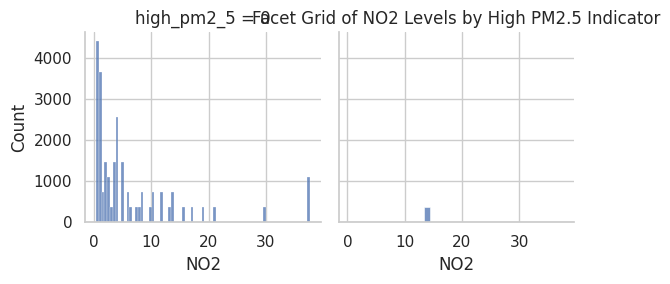

In [ ]:
mp.figure(figsize=(10, 6))
g = sn.FacetGrid(df, col='high_pm2_5')
g.map(sn.histplot, 'NO2')
mp.title('Facet Grid of NO2 Levels by High PM2.5 Indicator')
mp.show()

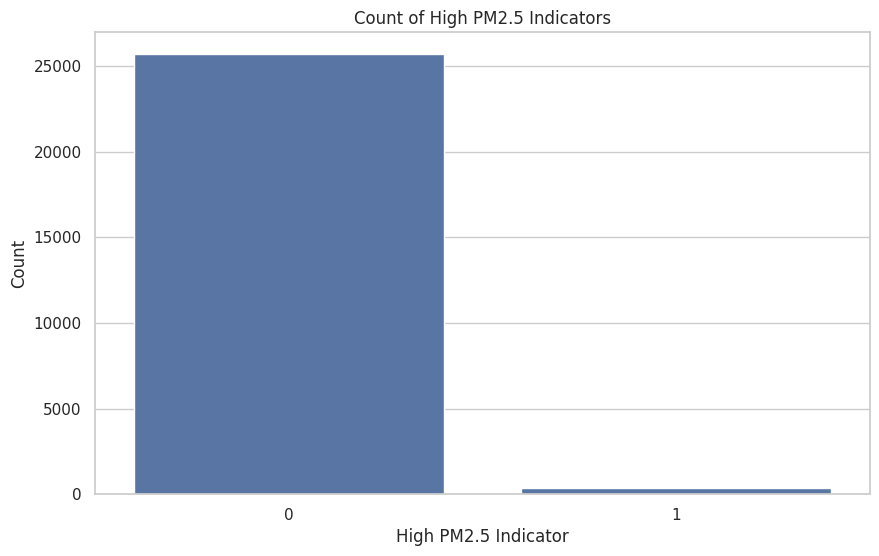

In [ ]:
mp.figure(figsize=(10, 6))
sn.countplot(x='high_pm2_5', data=df)
mp.title('Count of High PM2.5 Indicators')
mp.xlabel('High PM2.5 Indicator')
mp.ylabel('Count')
mp.show()

<Figure size 1000x600 with 0 Axes>

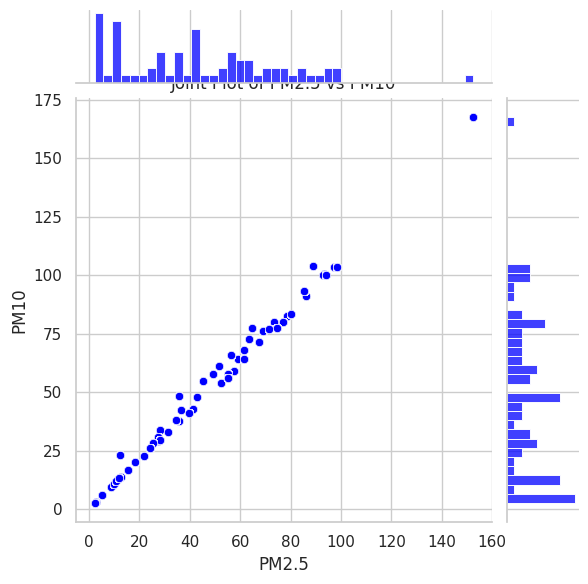

In [ ]:
mp.figure(figsize=(10, 6))
sn.jointplot(x='PM2.5', y='PM10', data=df, kind='scatter', color='blue')
mp.title('Joint Plot of PM2.5 vs PM10')
mp.show()

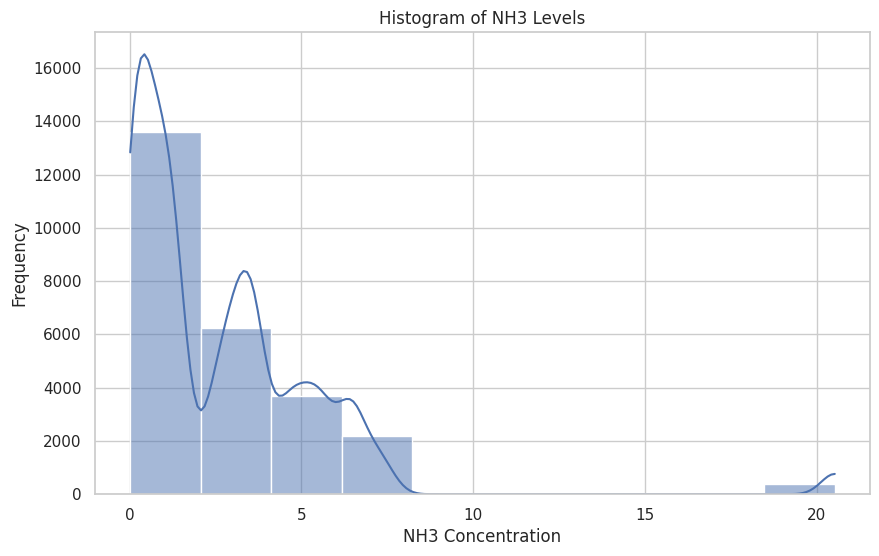

In [ ]:
mp.figure(figsize=(10, 6))
sn.histplot(df['NH3'], bins=10, kde=True)
mp.title('Histogram of NH3 Levels')
mp.xlabel('NH3 Concentration')
mp.ylabel('Frequency')
mp.show()

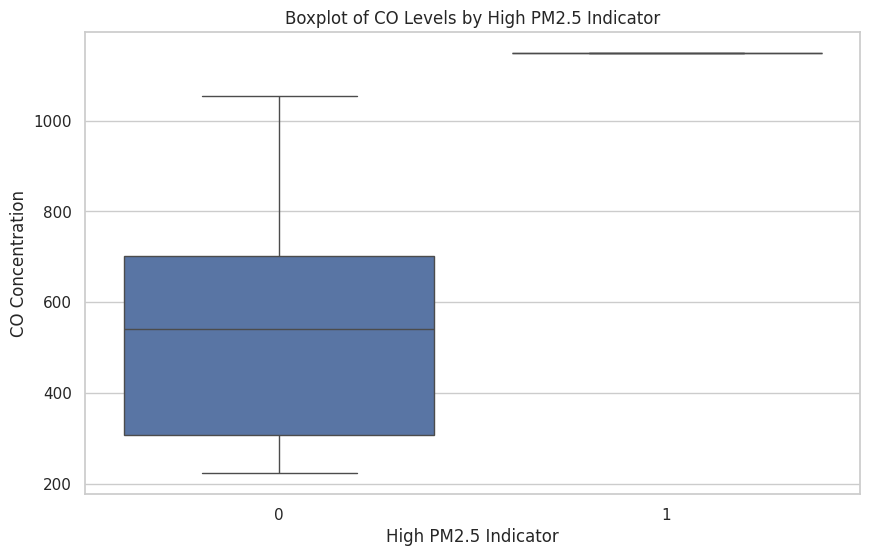

In [ ]:
mp.figure(figsize=(10, 6))
sn.boxplot(x='high_pm2_5', y='CO', data=df)
mp.title('Boxplot of CO Levels by High PM2.5 Indicator')
mp.xlabel('High PM2.5 Indicator')
mp.ylabel('CO Concentration')
mp.show()

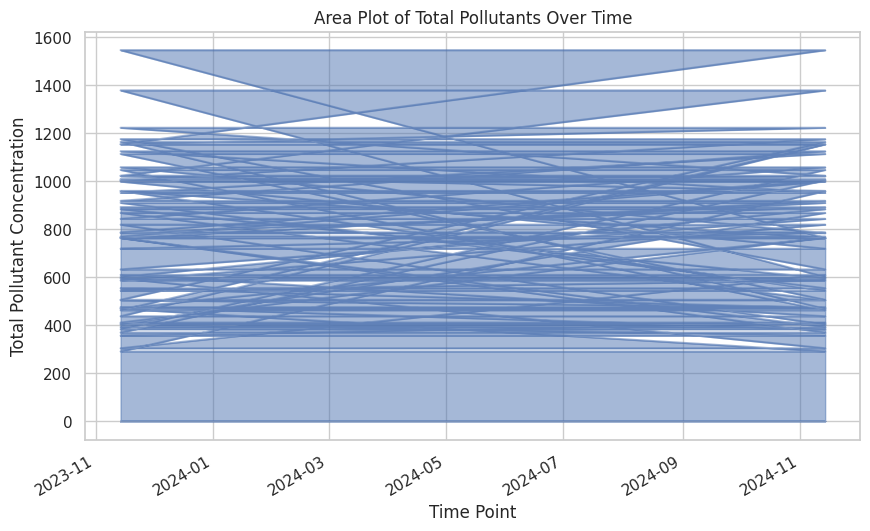

In [ ]:
mp.figure(figsize=(10, 6))
df['total_pollutant'].plot(kind='area', alpha=0.5)
mp.title('Area Plot of Total Pollutants Over Time')
mp.xlabel('Time Point')
mp.ylabel('Total Pollutant Concentration')
mp.show()

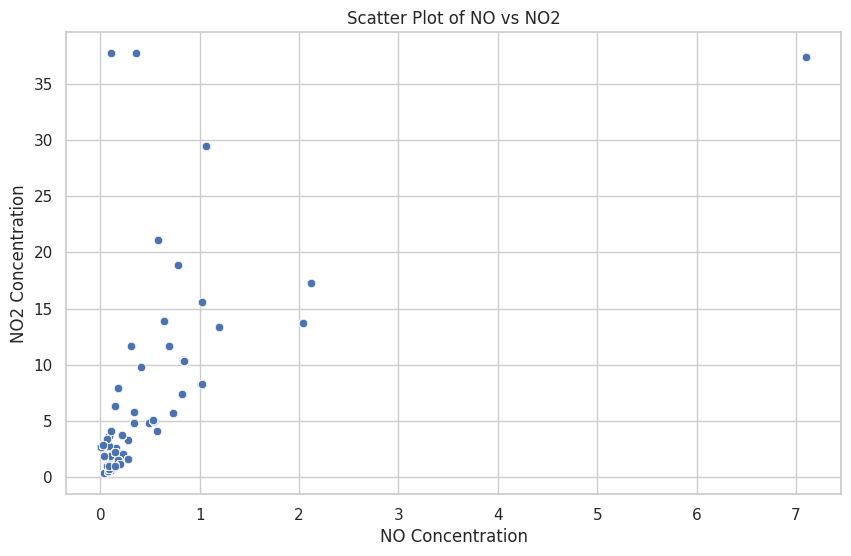

In [ ]:
mp.figure(figsize=(10, 6))
sn.scatterplot(x='NO', y='NO2', data=df)
mp.title('Scatter Plot of NO vs NO2')
mp.xlabel('NO Concentration')
mp.ylabel('NO2 Concentration')
mp.show()

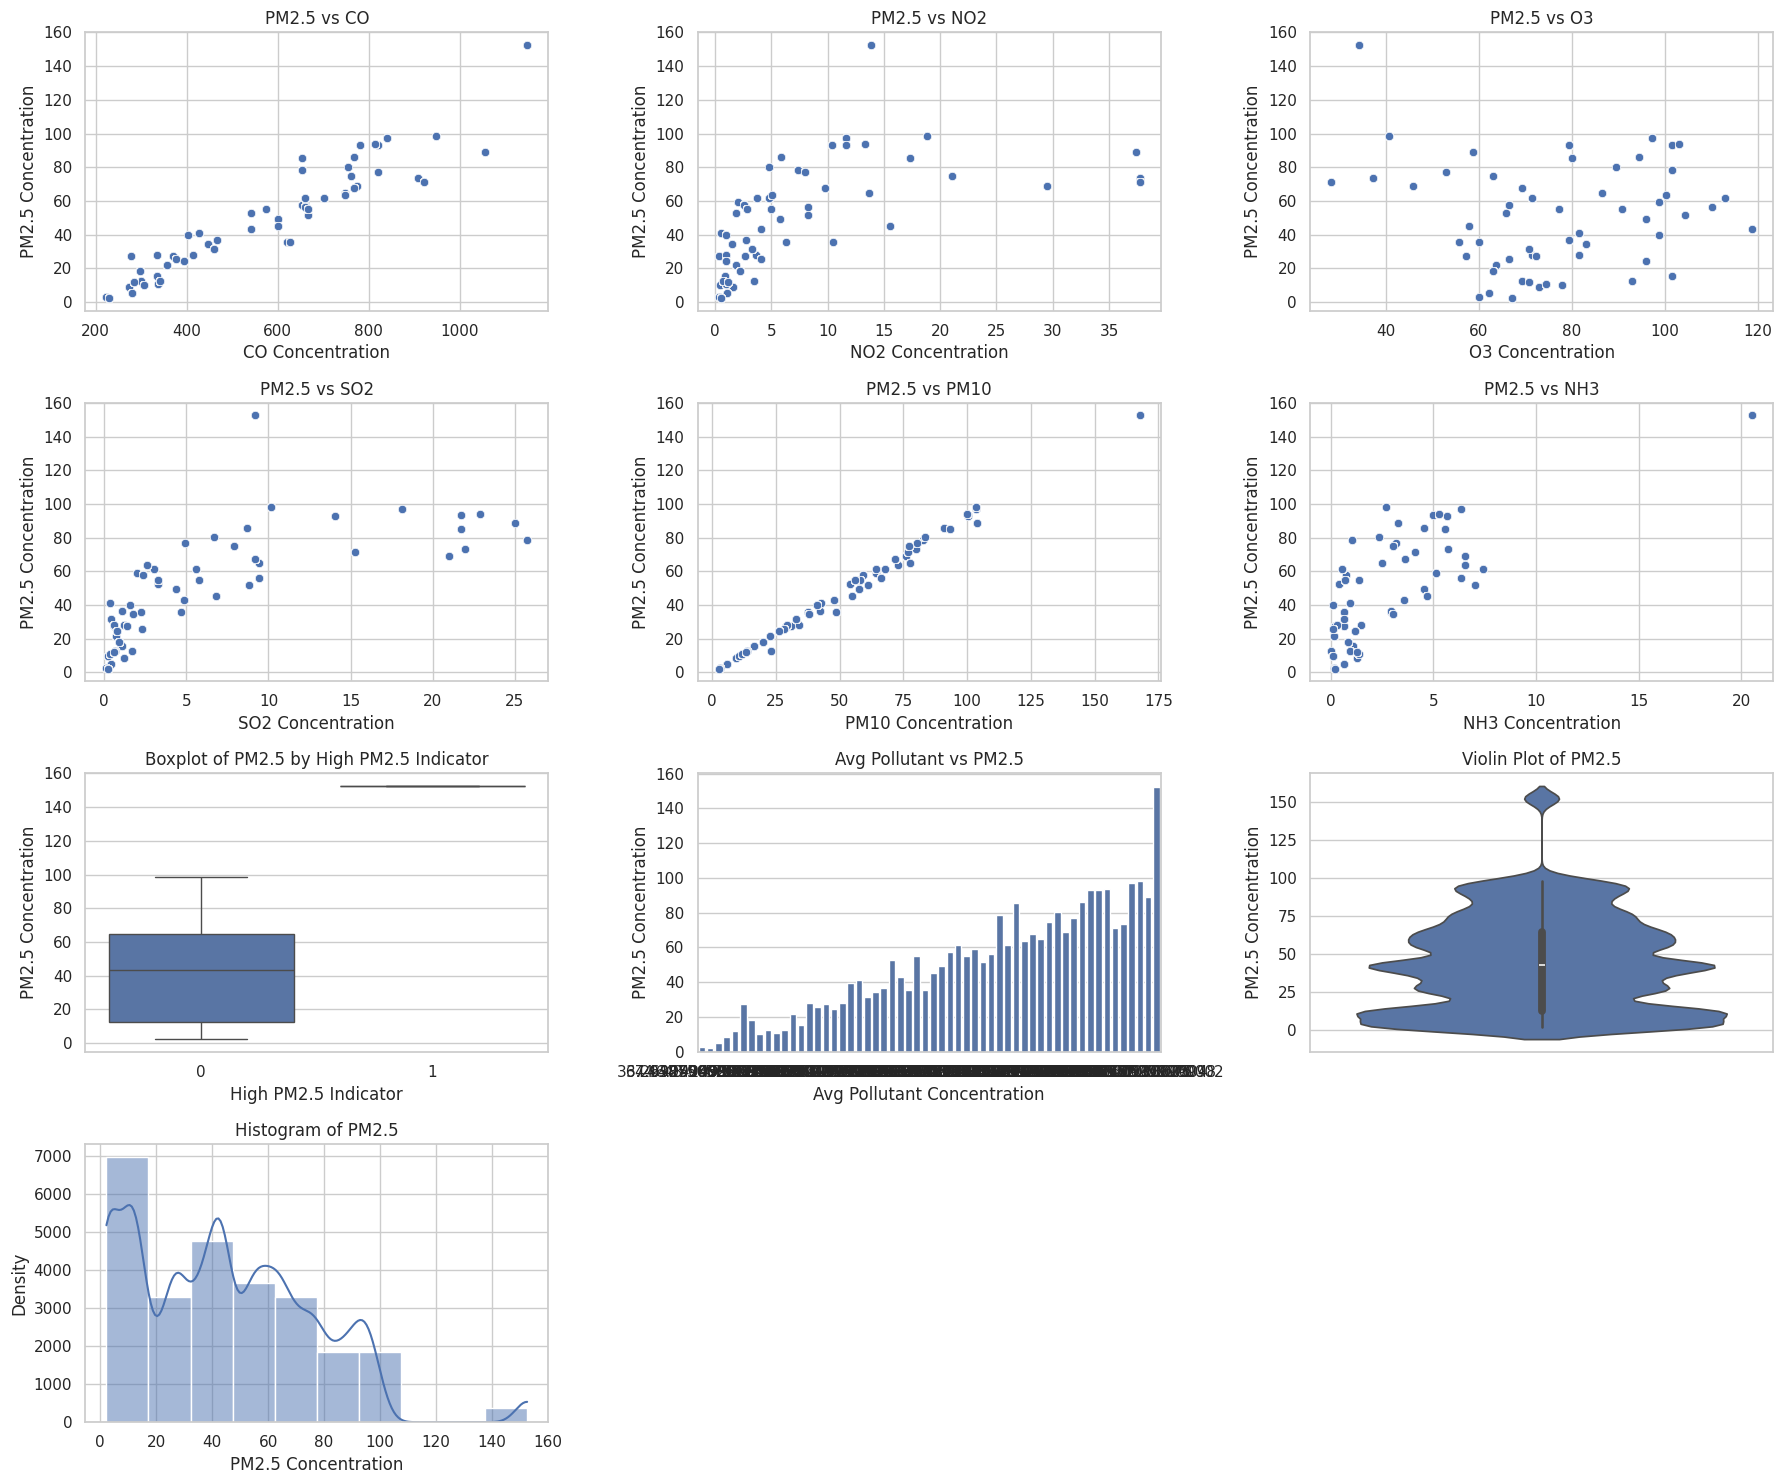

In [ ]:
# Đảm bảo style được cài đặt
sn.set(style="whitegrid")

# Tạo một hình vẽ với kích thước lớn
mp.figure(figsize=(18, 15))

# Biểu đồ scatter: PM2.5 vs CO
mp.subplot(4, 3, 1)
sn.scatterplot(x='CO', y='PM2.5', data=df)
mp.title('PM2.5 vs CO')
mp.xlabel('CO Concentration')
mp.ylabel('PM2.5 Concentration')

# Biểu đồ scatter: PM2.5 vs NO2
mp.subplot(4, 3, 2)
sn.scatterplot(x='NO2', y='PM2.5', data=df)
mp.title('PM2.5 vs NO2')
mp.xlabel('NO2 Concentration')
mp.ylabel('PM2.5 Concentration')

# Biểu đồ scatter: PM2.5 vs O3
mp.subplot(4, 3, 3)
sn.scatterplot(x='O3', y='PM2.5', data=df)
mp.title('PM2.5 vs O3')
mp.xlabel('O3 Concentration')
mp.ylabel('PM2.5 Concentration')

# Biểu đồ scatter: PM2.5 vs SO2
mp.subplot(4, 3, 4)
sn.scatterplot(x='SO2', y='PM2.5', data=df)
mp.title('PM2.5 vs SO2')
mp.xlabel('SO2 Concentration')
mp.ylabel('PM2.5 Concentration')

# Biểu đồ scatter: PM2.5 vs PM10
mp.subplot(4, 3, 5)
sn.scatterplot(x='PM10', y='PM2.5', data=df)
mp.title('PM2.5 vs PM10')
mp.xlabel('PM10 Concentration')
mp.ylabel('PM2.5 Concentration')

# Biểu đồ scatter: PM2.5 vs NH3
mp.subplot(4, 3, 6)
sn.scatterplot(x='NH3', y='PM2.5', data=df)
mp.title('PM2.5 vs NH3')
mp.xlabel('NH3 Concentration')
mp.ylabel('PM2.5 Concentration')

# Biểu đồ boxplot: PM2.5 theo chỉ báo high_pm2_5
mp.subplot(4, 3, 7)
sn.boxplot(x='high_pm2_5', y='PM2.5', data=df)
mp.title('Boxplot of PM2.5 by High PM2.5 Indicator')
mp.xlabel('High PM2.5 Indicator')
mp.ylabel('PM2.5 Concentration')

# Biểu đồ barplot: Trung bình các chất ô nhiễm vs PM2.5
mp.subplot(4, 3, 8)
sn.barplot(x='avg_pollutant', y='PM2.5', data=df)
mp.title('Avg Pollutant vs PM2.5')
mp.xlabel('Avg Pollutant Concentration')
mp.ylabel('PM2.5 Concentration')

# Biểu đồ violinplot: Phân bố của PM2.5
mp.subplot(4, 3, 9)
sn.violinplot(y='PM2.5', data=df)
mp.title('Violin Plot of PM2.5')
mp.ylabel('PM2.5 Concentration')

# Biểu đồ histogram: Phân phối PM2.5
mp.subplot(4, 3, 10)
sn.histplot(df['PM2.5'], bins=10, kde=True)
mp.title('Histogram of PM2.5')
mp.xlabel('PM2.5 Concentration')
mp.ylabel('Density')

# Điều chỉnh layout để tránh chồng chéo các phần tử
mp.tight_layout()
mp.show()


Ứng dụng thuật toán LSTM

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.iloc[:, 5:6].values)

In [ ]:
lookback = 60  # Số bước thời gian trước đó để sử dụng cho dự đoán

def create_dataset(data, lookback):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])  # Chọn dữ liệu từ bước thời gian trước đó
        y.append(data[i, 0])  # Chọn giá trị tại bước thời gian hiện tại
    return np.array(X), np.array(y)

# Giả sử scaled_data là dữ liệu đã được chuẩn hóa (scaled)
X, y = create_dataset(scaled_data, lookback)

# Chia dữ liệu thành tập huấn luyện (80%) và tập kiểm tra (20%)
X_train, X_test = X[:int(len(X)*0.8)], X[int(len(X)*0.8):]
y_train, y_test = y[:int(len(y)*0.8)], y[int(len(y)*0.8):]

# Định dạng lại X_train và X_test thành (samples, time_steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_train.shape, X_test.shape)  # In kích thước dữ liệu huấn luyện và kiểm tra


(20797, 60, 1) (5200, 60, 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

# Xây dựng mô hình Sequential
model = Sequential()

# Thêm lớp LSTM đầu tiên với return_sequences=True để giữ lại thông tin chuỗi thời gian
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Thêm Dropout để giảm overfitting

# Thêm lớp LSTM thứ hai với return_sequences=True để giữ lại thông tin cho lớp tiếp theo
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))  # Thêm Dropout để giảm overfitting

# Thêm lớp LSTM thứ ba với return_sequences=False để có đầu ra đơn cho lớp Dense
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))  # Thêm Dropout để giảm overfitting

# Thêm lớp Dense để tạo ra đầu ra cuối cùng (giá trị dự đoán)
model.add(Dense(units=1))

# Biên dịch mô hình với tối ưu hóa Adam và hàm mất mát MSE (Mean Squared Error)
model.compile(optimizer='adam', loss='mean_squared_error')

# Hiển thị thông tin về mô hình (tùy chọn)
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Định nghĩa EarlyStopping với tham số thích hợp
early_stop = EarlyStopping(
    monitor='val_loss',  # Theo dõi mất mát trên tập kiểm tra (validation loss)
    patience=5,  # Số epoch không cải thiện mất mát trước khi dừng huấn luyện
    restore_best_weights=True  # Khôi phục lại trọng số của mô hình với giá trị tốt nhất
)

# Huấn luyện mô hình
history = model.fit(
    X_train, y_train,  # Dữ liệu huấn luyện
    epochs=100,  # Số lần huấn luyện tối đa
    batch_size=32,  # Kích thước batch
    validation_split=0.2,  # Tỷ lệ chia dữ liệu cho validation (20% dữ liệu sẽ dùng để kiểm tra)
    callbacks=[early_stop]  # Sử dụng EarlyStopping trong quá trình huấn luyện
)


Epoch 1/100
520/520 ━━━━━━━━━━━━━━━━━━━━ 59s 105ms/step - loss: 0.0201 - val_loss: 0.0026
Epoch 2/100
520/520 ━━━━━━━━━━━━━━━━━━━━ 76s 93ms/step - loss: 0.0050 - val_loss: 0.0016
Epoch 3/100
520/520 ━━━━━━━━━━━━━━━━━━━━ 87s 102ms/step - loss: 0.0040 - val_loss: 0.0018
Epoch 4/100
520/520 ━━━━━━━━━━━━━━━━━━━━ 79s 97ms/step - loss: 0.0039 - val_loss: 9.0540e-04
Epoch 5/100
520/520 ━━━━━━━━━━━━━━━━━━━━ 52s 99ms/step - loss: 0.0036 - val_loss: 0.0012
Epoch 6/100
520/520 ━━━━━━━━━━━━━━━━━━━━ 94s 123ms/step - loss: 0.0031 - val_loss: 7.4140e-04
Epoch 7/100
520/520 ━━━━━━━━━━━━━━━━━━━━ 68s 96ms/step - loss: 0.0031 - val_loss: 7.4680e-04
Epoch 8/100
520/520 ━━━━━━━━━━━━━━━━━━━━ 81s 94ms/step - loss: 0.0029 - val_loss: 7.3578e-04
Epoch 9/100
520/520 ━━━━━━━━━━━━━━━━━━━━ 82s 94ms/step - loss: 0.0029 - val_loss: 6.9951e-04
Epoch 10/100
520/520 ━━━━━━━━━━━━━━━━━━━━ 85s 101ms/step - loss: 0.0032 - val_loss: 7.7026e-04
Epoch 11/100
520/520 ━━━━━━━━━━━━━━━━━━━━ 82s 102ms/step - loss: 0.0029 - val_los

163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step
Test RMSE: 0.29537939932390833


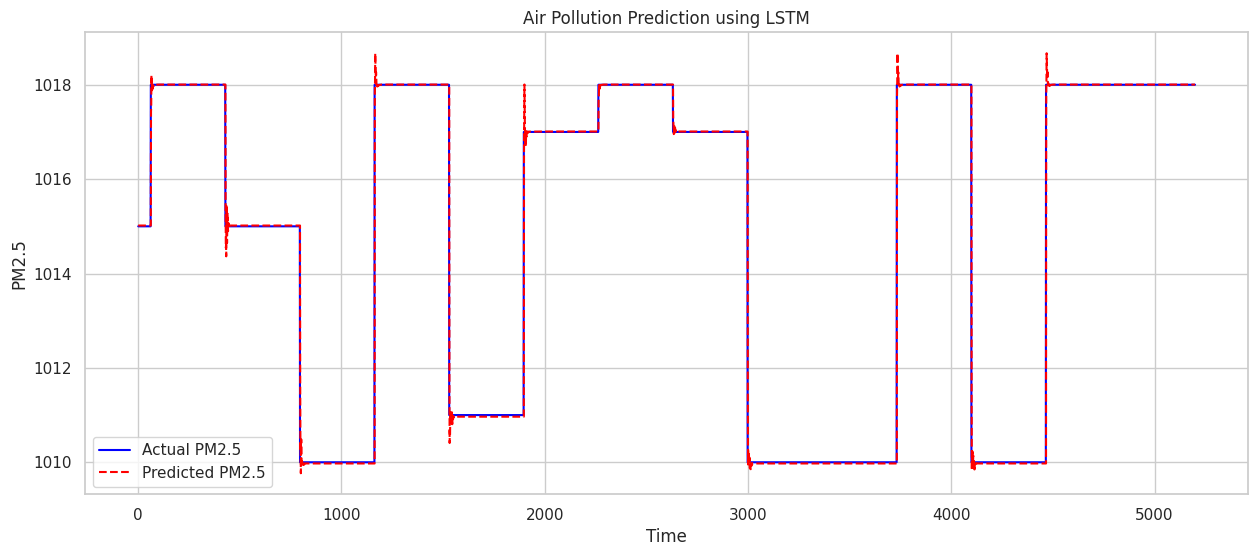

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Dự đoán giá trị PM2.5
y_pred = model.predict(X_test)

# Invert lại quá trình chuẩn hóa
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Tính toán RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print('Test RMSE:', rmse)

# Vẽ đồ thị so sánh giá trị thực và giá trị dự đoán
plt.figure(figsize=(15, 6))
plt.plot(y_test_inv, label='Actual PM2.5', color='blue')
plt.plot(y_pred_inv, label='Predicted PM2.5', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.title('Air Pollution Prediction using LSTM')
plt.legend()
plt.show()


LSTM Metrics:
MAE: 0.03, MSE: 0.09, RMSE: 0.30, R²: 0.99


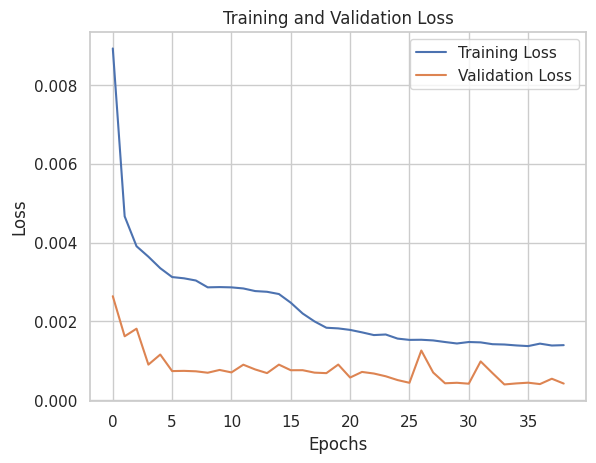

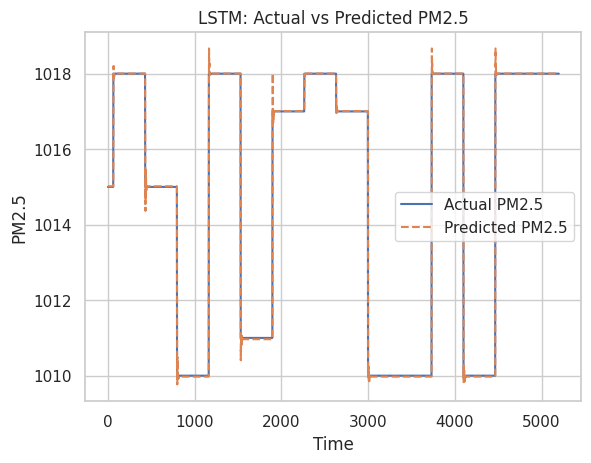

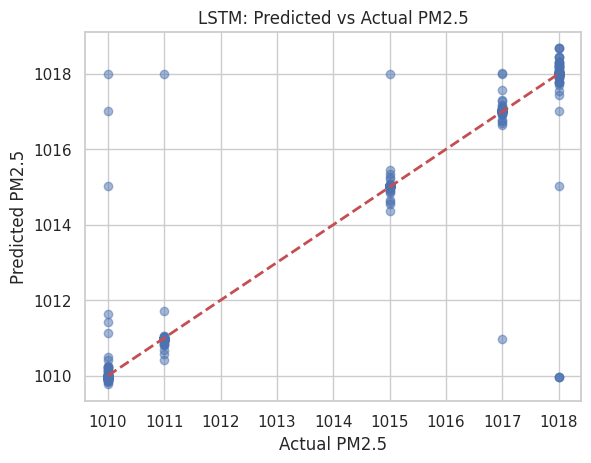

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
# Metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)
print(f"LSTM Metrics:\nMAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot predictions
plt.plot(y_test_inv, label='Actual PM2.5')
plt.plot(y_pred_inv, label='Predicted PM2.5', linestyle='--')
plt.title('LSTM: Actual vs Predicted PM2.5')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

# Scatter plot of predictions
plt.scatter(y_test_inv, y_pred_inv, alpha=0.5)
plt.plot([y_test_inv.min(), y_test_inv.max()], [y_test_inv.min(), y_test_inv.max()], '--r', linewidth=2)
plt.title('LSTM: Predicted vs Actual PM2.5')
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')
plt.show()


In [ ]:
# Tạo chuỗi thời gian PM2.5 từ cột 'pm2.5'
pm25_series = df['pm2.5']

# Chia dữ liệu thành tập huấn luyện và kiểm tra cho ARIMA
train_size = int(len(pm25_series) * 0.8)
train, test = pm25_series[:train_size], pm25_series[train_size:]

# Tạo mô hình ARIMA với thông số (5, 1, 0)
from statsmodels.tsa.arima.model import ARIMA
arima_model = ARIMA(train, order=(5, 1, 0))
arima_result = arima_model.fit()

# Dự báo PM2.5 cho tập kiểm tra
forecast = arima_result.forecast(steps=len(test))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

In [ ]:
# Tính toán RMSE cho mô hình ARIMA
arima_rmse = np.sqrt(mean_squared_error(test, forecast))

# In kết quả RMSE cho ARIMA
print(f"ARIMA RMSE: {arima_rmse:.2f}")


ARIMA RMSE: 35.47


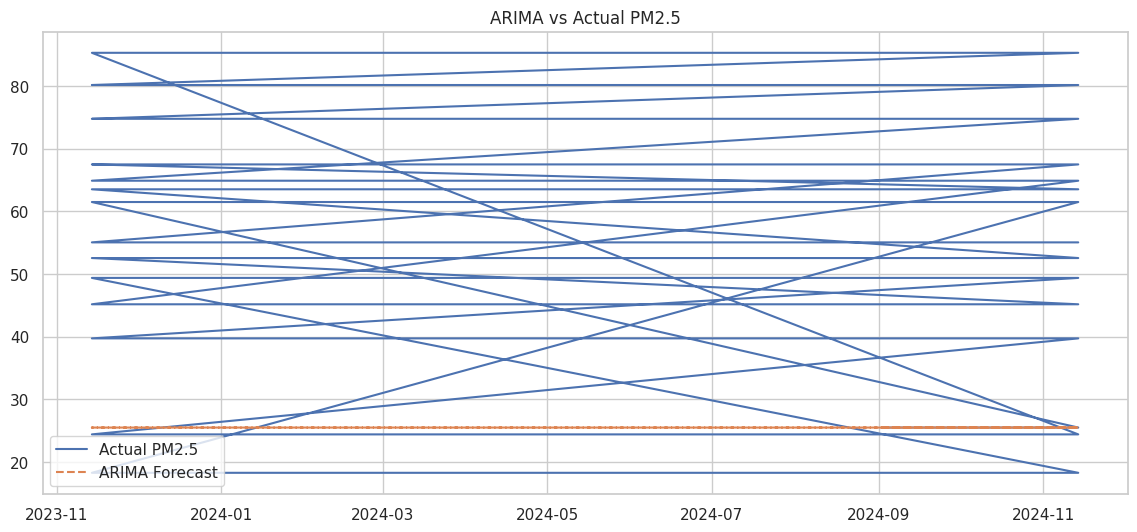

In [ ]:
# Vẽ đồ thị so sánh giữa dự báo ARIMA và giá trị thực tế PM2.5
plt.figure(figsize=(14, 6))
plt.plot(test.index, test, label='Actual PM2.5')
plt.plot(test.index, forecast, label='ARIMA Forecast', linestyle='--')
plt.title('ARIMA vs Actual PM2.5')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix, accuracy_score
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
# Dữ liệu phân loại
X_clf = X.copy()
y_clf = df['aqi_category']


In [ ]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra cho phân loại
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

# Tạo mô hình phân loại Random Forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_clf, y_train_clf)

# Dự đoán các lớp AQI
y_pred_clf = clf.predict(X_test_clf)


In [ ]:
# Đánh giá mô hình phân loại với các chỉ số như accuracy, precision, recall, f1-score
accuracy = accuracy_score(y_test_clf, y_pred_clf)
print("Classification Metrics:")
print(classification_report(y_test_clf, y_pred_clf))
print(f"Accuracy: {accuracy:.2f}")


Classification Metrics:
              precision    recall  f1-score   support

        Good       1.00      1.00      1.00      3135
    Moderate       1.00      1.00      1.00      2011
   Unhealthy       1.00      1.00      1.00        66

    accuracy                           1.00      5212
   macro avg       1.00      1.00      1.00      5212
weighted avg       1.00      1.00      1.00      5212

Accuracy: 1.00


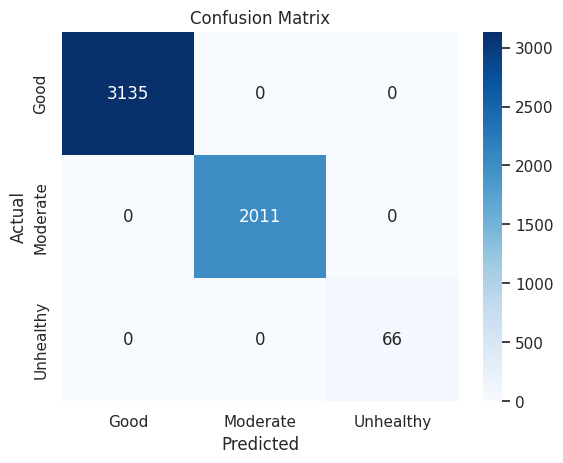

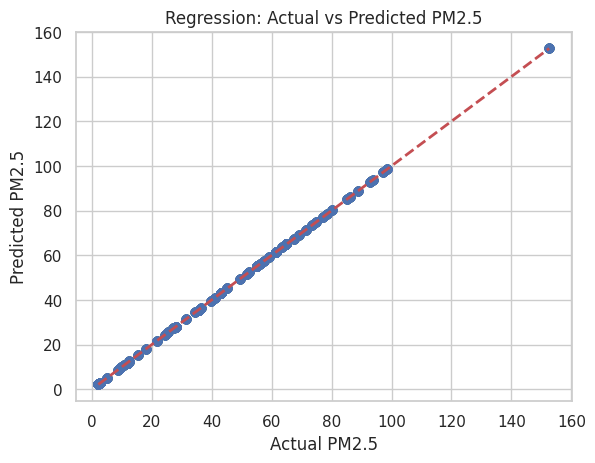

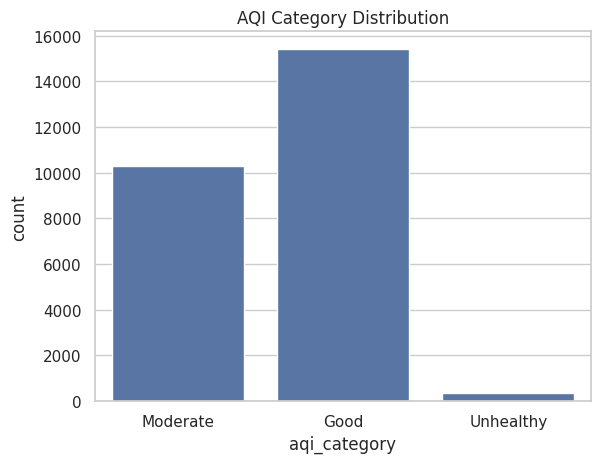

In [ ]:
# Vẽ ma trận nhầm lẫn để phân tích kết quả phân loại
conf_matrix = confusion_matrix(y_test_clf, y_pred_clf)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
# Vẽ đồ thị phân tán giữa giá trị thực tế và giá trị dự đoán PM2.5
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.title('Regression: Actual vs Predicted PM2.5')
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')
plt.show()
# Vẽ biểu đồ cột để trực quan hóa phân bố các mức AQI
sns.countplot(data=df, x='aqi_category')
plt.title('AQI Category Distribution')
plt.show()
